In [2]:
%load_ext autoreload
%autoreload
import pandas as pd
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import svds
from scipy.spatial.distance import cosine
from scipy import sparse
from script import cf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import Data

Input data includes:
- User Info (sex, income)
- Item Info (BOW, TF-IDF)
- User-Item Interaction
    - active/explicit: rating
    - passive/implicit: clickstream analysis


Input data dimension
- Can be million+ user
- Can be 10k+ products

Load example data

In [2]:
header = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('./data/ml-100k/u.data', sep='\t', names=header)
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [3]:
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
print ('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_items))

Number of users = 943 | Number of movies = 1682


# Content-basd Recommendation

- Calculate **similarity** between **items** of **ONE user**
- Similarity is calculated based on item attribute (for example, location, price, cuisine, etc.)
    - Output: An item space with defined distance
- One model for one user; No interaction between users

# Memory-based CF

In [4]:
df_matrix = np.zeros((n_users, n_items))
for line in df.itertuples():
    df_matrix[line[1]-1, line[2]-1] = line[3]
df_matrix.shape

(943, 1682)

## Define Cosine Similarity
$Similarity = cos(\theta) = \frac{\mathbf A \cdot \mathbf B }{||\mathbf A|| \ ||\mathbf B|| }$

In [5]:
###
user_similarity = np.zeros((n_users, n_users))
for i in range(n_users):
    u= df_matrix[i,]
    for j in range(n_users):
        v= df_matrix[j,]
        user_similarity[i,j] = np.dot(u,v) / (np.linalg.norm(u,ord=2) * np.linalg.norm(v,ord=2)) 

In [6]:
from sklearn.metrics.pairwise import pairwise_distances
user_similarity = pairwise_distances(df_matrix, metric='cosine')
user_similarity.shape

(943, 943)

In [7]:
item_similarity = pairwise_distances(df_matrix.T, metric='cosine')
item_similarity.shape

(1682, 1682)

## Evaluation metrics

- Rating prediction: RMSE, MAE
- Top-k rating precision: Precision, Recall, AUC
    - % of the top-k recommendations that were actually used by user
- Possible benchmark model: global top-k recommendations

## Prediction

### User-Item Filtering
- Users who are similar to you also liked ...
- Prediction for user **k** for movie **m** :

- Prediction = User **k** bias + adjustmemnt from similar user
    - $ \hat{x}_{k,m} = \bar x_k + \frac{\Delta}{Norm}  $


- Adjustment = (similarity with another user) * (rating of another user - bias of another user)
    - $ \Delta = \sum_{k_0}UserSim(k, k_0) \cdot (x_{k_0, m} - \bar x_{k0})$

    - $ Norm = \sum_{k_0}|UserSim(k, k_0)|$


In [8]:
%%writefile ./script/cf.py
import numpy as np

def ui_predict(ratings, similarity):
    all_user_mean = ratings.mean(axis = 1)
    ratings_diff = (ratings - all_user_mean[:, np.newaxis]) # (943, 1682)
    
    adjust = similarity.dot(ratings_diff)
    norm = np.array([np.abs(similarity).sum(axis=1)]).T

    pred = all_user_mean[:, np.newaxis] + adjust / norm
    
    return pred


Overwriting ./script/cf.py


In [9]:
from script.cf import *
cf.ui_predict(df_matrix, user_similarity).shape

(943, 1682)

### Item-Item Filtering
Users who liked this item also liked ...

   - $ \hat{x}_{k,m} = \sum_{m_0}ItemSim(m, m_0) \cdot x_{k, m_0} / Norm$

In [10]:
%%writefile -a ./script/cf.py

def ii_predict(ratings, similarity):
    norm = np.array([np.abs(similarity).sum(axis=1)])
    pred = ratings.dot(similarity)  / norm
    return pred

Appending to ./script/cf.py


In [11]:
cf.ii_predict(df_matrix, item_similarity).shape

(943, 1682)

# Model-Based CF 

## Matrix Factorization
Singular-Value-Decomposition

<img src="https://cambridgespark.com/content/tutorials/implementing-your-own-recommender-systems-in-Python/figures/BLOG_CCA_4.png" width="400">


- $M = U \times \Sigma \times V^T  $ Note: $\Sigma$ can be multipled to U or V
- Con: need default value for missing value in rating matrix
- U and V are low-dimention latent vectors (**Embeddings**) for users and movies. 


- Alternative approach: $Min(L) = \sum_{i,j}{(u_i v_j - x_{ij})^2} + Regularization (u,v)$; solved by SGD

In [52]:
u, s, vt = svds(df_matrix, k = 20)
s_diag_matrix = np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)

<img src="https://cdn-images-1.medium.com/max/1760/1*2i-GJO7JX0Yz6498jUvhEg.png" width="600">


## Other methods: 
- Probabilistic factorization (PMF)
    * P = dot_product(i,j) + User_i_bias + movie_j_bias + intercept
- Non-negative factorization (NMF)

## Hybrid

- Weighted rankings from two models
- Cascade: 1) Accurate model -> rough rank; 2) 2nd one to refine
- Treat collaborative factors as extra feature for content-based model

# Model-Based CF - Deep Learning

- Main difference with SVD
    - Don't require orthogonal vectors as in SVD
    - Learn the embedding by itself
    - Allows non-linearity instead of just dot product
    
- Extra benefits
    - Can incoporate additional features like user profile
    

## Model Types

### Basic Idea V1
- One-hot encoding for user i
- Hiddern layer: Embedding layer for users
    - Weights: latent vector for users
    
    
- Output layer: output ratings for each item j
    - Weights: latent vector for movies
    
    
###  Basic Idea V2
- One-hot encoding for user i
- Hiddern layer: Embedding layer for users
    - Weights: latent vector for users
    
    
- One-hot encoding for item j
- Hidden layer: output ratings for each movie j
    - Weights: latent vector for movies


- More hidden layers

<img src="https://image.slidesharecdn.com/neuralcollaborativefiltering-170528094418/95/neural-collaborative-filtering-9-638.jpg?cb=1496201763" width="600">
    

###  A lot of other DL network types    

Example: https://arxiv.org/abs/1708.05031
<img src="https://nipunbatra.github.io/blog/2017/neumf.png" width="600">



## Example in Keras

In [54]:
import keras
from IPython.display import SVG
from keras import Model
from keras.optimizers import Adam
from keras.layers import Input, Embedding, Flatten, Dot, Concatenate, Dense, Dropout
from keras.utils.vis_utils import model_to_dot

### Model Params

In [55]:
n_latent_factors = 20

### Define Model

In [56]:
item_input = Input(shape = [1], name = 'Item-input')
item_embedding = Embedding(n_items, n_latent_factors, name = 'Item-embedding')(item_input)
item_flat = Flatten(name = 'Item-flatten')(item_embedding)

In [57]:
user_input = Input(shape = [1], name = 'User-input')
user_embedding = Embedding(n_users, n_latent_factors, name = 'User-embedding')(user_input)
user_flat = Flatten(name = 'User-flatten')(user_embedding)

**Option1**

In [58]:
dotprod = Dot(axes=1, name='DotProduct')([item_flat, user_flat])
model = Model([item_input, user_input ], dotprod)
model.compile('adam', 'mean_squared_error')

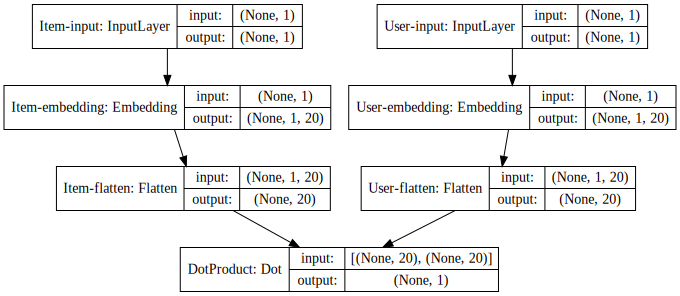

In [59]:
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

**Option2**

In [63]:
concatenate = Concatenate(name='Concatenate')([item_flat, user_flat])
dropout = Dropout(0.2,name='Dropout')(concatenate)
dense_1 = Dense(20,activation='relu', name='FC-1')(dropout)
activation = Dense(1, activation='relu', name='Activation')(dense_1)
model = Model([item_input, user_input ], activation)
model.compile('adam', 'mean_squared_error')

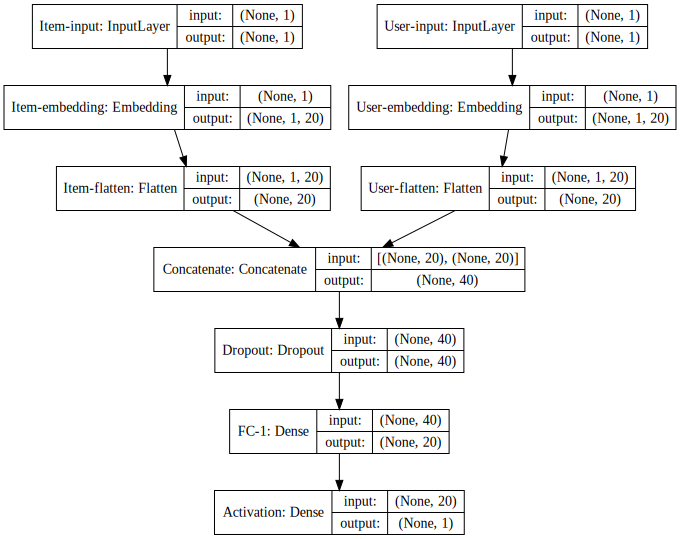

In [64]:
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

### Model Training

In [65]:
#https://keras.io/models/model/
model.fit(x = [df.item_id - 1, df.user_id - 1], 
          y = df.rating, 
          epochs = 15, 
          verbose = 2, 
          validation_split = 0.2)

Train on 80000 samples, validate on 20000 samples
Epoch 1/15
 - 4s - loss: 1.5278 - val_loss: 0.9136
Epoch 2/15
 - 3s - loss: 0.9126 - val_loss: 0.8956
Epoch 3/15
 - 3s - loss: 0.8964 - val_loss: 0.8882
Epoch 4/15
 - 3s - loss: 0.8809 - val_loss: 0.8799
Epoch 5/15
 - 3s - loss: 0.8614 - val_loss: 0.8652
Epoch 6/15
 - 3s - loss: 0.8486 - val_loss: 0.8639
Epoch 7/15
 - 3s - loss: 0.8381 - val_loss: 0.8644
Epoch 8/15
 - 3s - loss: 0.8255 - val_loss: 0.8608
Epoch 9/15
 - 3s - loss: 0.8156 - val_loss: 0.8549
Epoch 10/15
 - 3s - loss: 0.8033 - val_loss: 0.8568
Epoch 11/15
 - 3s - loss: 0.7958 - val_loss: 0.8511
Epoch 12/15
 - 3s - loss: 0.7857 - val_loss: 0.8489
Epoch 13/15
 - 3s - loss: 0.7771 - val_loss: 0.8513
Epoch 14/15
 - 3s - loss: 0.7703 - val_loss: 0.8451
Epoch 15/15
 - 3s - loss: 0.7656 - val_loss: 0.8548


### Extract Weight

In [66]:
model.get_layer(name='User-embedding').get_weights()[0].shape

(943, 20)

In [67]:
model.get_layer(name='Item-embedding').get_weights()[0].shape

(1682, 20)

# Ranking Algorithms

- Top-K ranking problem instead of rating prediction problem
- More consistent with practical user needs

## How to evaluate a ranking system

<img src="https://qph.ec.quoracdn.net/main-qimg-18cd74b05b850406e1c01b76b1cb8fd6?convert_to_webp=true" width="400">


### AP (Average Precision)

$Average Precision = \frac{\sum_{k=1}^{N}{P(k) * rel(k)}}{K} $
- $P(k)$ is precision of first k results
- $rel(k)$ is binary value 0/1
- $K$ is total number of relevant items

<img src="https://slideplayer.com/2295316/8/images/4/Mean+Average+Precision.jpg" width="400">

### Normalized Discounted Cumulative Gain

- The premise of DCG is that highly relevant documents appearing lower in a search result list should be penalized as the graded relevance value is reduced logarithmically proportional to the position of the result.
- Note: rel(i) here can be any value instead of binary

<img src="https://image.slidesharecdn.com/colmujsktqk4sh7faxcd-signature-f4a0831a458d6bbb78c09b1a397c3517fe8a2c82e9751f039f832a3be97b108f-poli-141208101339-conversion-gate02/95/florian-douetteau-dataiku-7-638.jpg?cb=1418033719" width="400">

https://en.wikipedia.org/wiki/Discounted_cumulative_gain

## Modelling Approach

- Pointwise
    - Given user u and item i, predict score x
    - Not necessary, since the score is not important; ranked list is important.
    - Actually solving a *regression* problem
    - The relationships between documents sometimes not considered
    - Usually: regression, classification, etc
    
<img src="https://image.slidesharecdn.com/l2rrecysystutaly-final-131012040539-phpapp01/95/learning-to-rank-for-recommender-systems-acm-recsys-2013-tutorial-40-638.jpg?cb=1381555055" width="400">
    
    
- Pairwise
    - Goal is to correctly determine a>b or a<b for each document pair
    - The scale of difference is ignored

<img src="https://image.slidesharecdn.com/l2rrecysystutaly-final-131012040539-phpapp01/95/learning-to-rank-for-recommender-systems-acm-recsys-2013-tutorial-46-638.jpg?cb=1381555055" width="400">

- Listwise
    - Directly optimize final performance metric
    - More complicated modelling
    
<img src="http://baogege.info/img/learning-to-rank-for-recommender-system/listwiseltrrs.png" width="400">    


# CTR (Click-Through Rate) Prediction

## Problem Statement

Given (user, item, context): predict click = 0/1
- Goal: $P(Click=1|User, Item, Context)$
- Difference: in recommendation system and in online ad. 
- The former mainly cares about ranking, while the latter cares about accuracy, because it contributes to revenue.

## Modelling Approach - 1

Ref: 
- https://pnyuan.github.io/blog/ml_practice/Kaggle%E6%BB%91%E6%B0%B4%20-%20CTR%E9%A2%84%E4%BC%B0%EF%BC%88GBDT-LR%EF%BC%89/
- http://ailab.criteo.com/ctr-prediction-linear-model-field-aware-factorization-machines/
- http://kubicode.me/2018/02/23/Deep%20Learning/Deep-in-out-Factorization-Machines-Series/

- Logistic Regression + Feature Engineering (Linear Model)
    - Main problem: feature combination, high-order interaction
    
    
- Degree-2 Polynomial Mappings 
    - Combine features by $y(X)=w_0 + \sum_{i=1}^{N}{w_{1i}x_i} + \sum_{i=1}^{N}\sum_{j=i+1}^{N}{w_{2ij}x_ix_j} $, where N is number of features
    - Sparse data
    - High dimension: $O(n^2)$
    - Make trivial prediction on those unseen pairs
    
<img src="http://ailab.criteo.com/wp-content/uploads/2017/03/Screen-Shot-2017-02-10-at-11.12.46-AM-789x121.png" width="400">   

- Known: for matrix W, and a large K, $W \approx VV^T$, i.e., $w_{ij} \approx <v_i, v_j>$
- Factorization Machine (FM)
    -  $y(X)=w_0 + \sum_{i=1}^{N}{w_{1i}x_i} + \sum_{i=1}^{N}\sum_{j=i+1}^{N}{<v_i, v_j>x_ix_j} $
    - $v_i, v_j - R^{N \times K}$, latent vector for feature i and j with embedding length $K$
    - Reasonable prediction for unseen pairs
    - Lower dimension: $O(N \times K)$

    
<img src="http://ailab.criteo.com/wp-content/uploads/2017/03/Screen-Shot-2017-02-10-at-11.12.53-AM-768x301.png" width="400">   

- Field Factorization Machine (FFM)
    - Split the original latent space into many “smaller” latent spaces,  and depending on the fields of features, one of them is used.
    - $y(X)=w_0 + \sum_{i=1}^{N}{w_{1i}x_i} + \sum_{i=1}^{N}\sum_{j=i+1}^{N}{<v_{i, f_j}, v_{j, f_i}>x_ix_j} $
<img src="http://ailab.criteo.com/wp-content/uploads/2017/03/Screen-Shot-2017-02-10-at-11.13.03-AM-768x230.png" width="400"> 


- GBDT + LR (Mixed)
    - GBDT transforms features, reduced dimensions, combined attributes
    - The leaves serve as new input features for LR
<img src="https://raw.githubusercontent.com/PnYuan/Practice-of-Machine-Learning/master/imgs/Kaggle_CTR/gbdt-lr/gbdt-lr_2.png" width="500">


## Modelling Approach - 2

- Wide and Deep
    - Memorization: learning the directly relevant frequent co-occurrence of items;
    - Generalization: improving the diversity exploring new items combinations that have never or rarely occurred in the past.
    - **Wide**: LR for categorical variables --> Memorization
    - **Deep**: DNN for continous/categorical variables --> Generalization
<img src="https://1.bp.blogspot.com/-Dw1mB9am1l8/V3MgtOzp3uI/AAAAAAAABGs/mP-3nZQCjWwdk6qCa5WraSpK8A7rSPj3ACLcB/s1600/image04.png" width="800">

<img src="http://edarchimbaud.github.io/img/2016-11-22-wide-and-deep-learning-for-recommender-systems/Screenshot%20from%202016-11-22%2021-07-22.png" width="600">



- Deep FM
    - Ref: https://www.ijcai.org/proceedings/2017/0239.pdf
    - FM and Deep parts shares the same inputs; In wide&deep, the two parts are independent
    - Compared with wide&deep based on manually created features, Deep FM contains the inner product of feature latent vectors (automatically)
    - $y_{DeepFm}=sigmoid(y_{FM}+y_{DNN})$
<img src="https://pic3.zhimg.com/v2-3802463cd31639e103d301cf42ced6b4_r.jpg" width="600">



# Possible A/B Test

https://medium.com/nikeengineering/serving-athletes-with-personalized-workout-recommendations-285491eabc3d

- Group: 
50 percent baseline as the Champion 
50 percent Collaborative Filtering 

- KPI: 
User actually start a workout that shown from a recommended section


# Reference
- https://arxiv.org/pdf/1606.07792.pdf
- https://www.slideshare.net/kerveros99/deep-learning-for-recommender-systems-recsys2017-tutorial?from_action=save
- https://medium.com/recombee-blog/machine-learning-for-recommender-systems-part-1-algorithms-evaluation-and-cold-start-6f696683d0ed
- https://www.slideshare.net/microlife/recommender-systems-contentbased-and-collaborative-filtering
- https://www.slideshare.net/LadislavPeska/towards-recommender-systems-for-police-photo-lineup?next_slideshow=1
- https://nycdatascience.com/blog/student-works/capstone/metarecommendr-recommendation-system-video-games-movies-tv-shows/
- https://www.researchgate.net/publication/317558508_Item_Silk_Road_Recommending_Items_from_Information_Domains_to_Social_Users?enrichId=rgreq-ea35906fbd73392cb2fd6212acddf950-XXX&enrichSource=Y292ZXJQYWdlOzMxNzU1ODUwODtBUzo2MDM1NDY3NDc2ODY5MThAMTUyMDkwODE2NjY0OQ%3D%3D&el=1_x_3&_esc=publicationCoverPdf
- https://www.jianshu.com/p/005a4e6ac775
